# Application 2: Christmas model

In [ ]:
from ssm4epi.models.reporting_delays import (
    account_for_nans,
    _model,
    to_log_probs,
    n_iterations,
    N_meis,
    N_mle,
    N_posterior,
    key,
    percentiles_of_interest,
)
from pyprojroot.here import here

In [ ]:
import jax

jax.config.update("jax_enable_x64", True)

In [ ]:
import pandas as pd
import jax.random as jrn
from jax import numpy as jnp, vmap
from isssm.laplace_approximation import laplace_approximation as LA
from isssm.modified_efficient_importance_sampling import (
    modified_efficient_importance_sampling as MEIS,
)
from isssm.estimation import mle_pgssm, initial_theta
from isssm.importance_sampling import (
    pgssm_importance_sampling,
    ess_pct,
    mc_integration,
    prediction_percentiles,
    normalize_weights,
)
from isssm.kalman import state_mode
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.figsize"] = (20, 6)

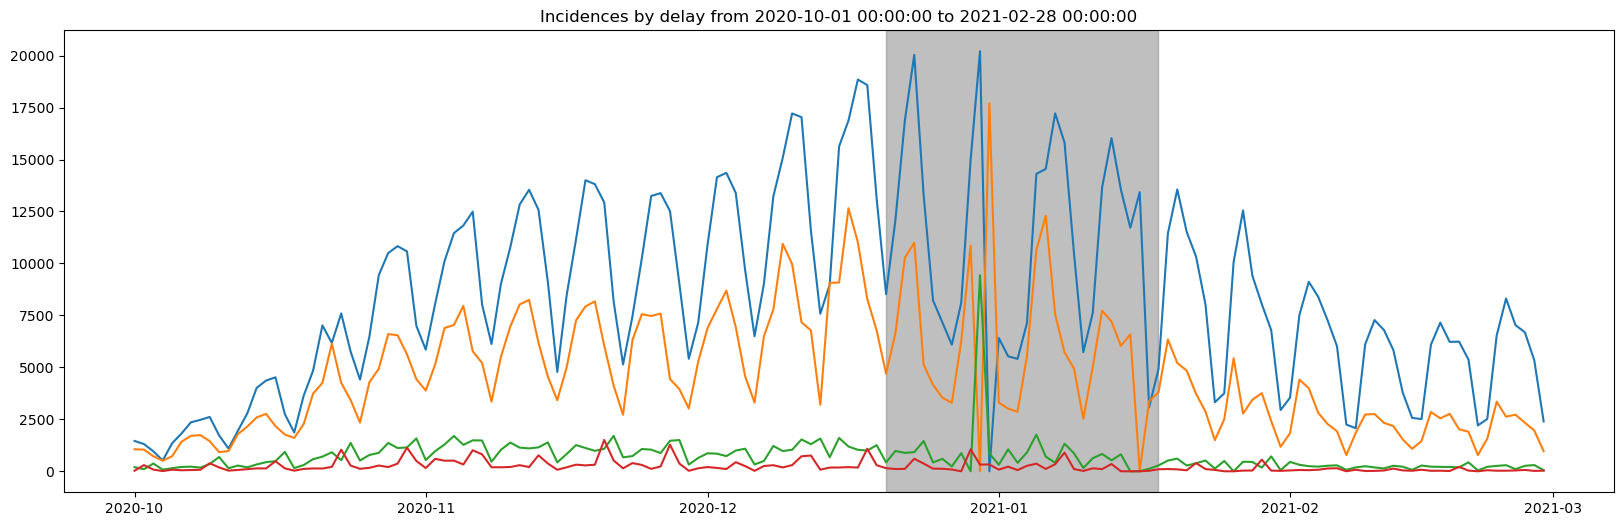

In [ ]:
i_start = 179
np1 = 151
df = pd.read_csv(here() / "data/processed/RKI_4day_rt.csv")
dates = pd.to_datetime(df.iloc[i_start : i_start + np1, 0])
christmas_start, christmas_end = 80, 109
christmas_ilocs = jnp.arange(christmas_start, christmas_end + 1).astype(int)

y = jnp.asarray(df.iloc[i_start : i_start + np1, 1:].to_numpy())

plt.plot(dates, y)
plt.title(f"Incidences by delay from {dates.iloc[0]} to {dates.iloc[-1]}")
plt.axvspan(
    dates.iloc[christmas_start],
    dates.iloc[christmas_end],
    color="grey",
    alpha=0.5,
)
plt.show()

In [ ]:
theta_fitted_miss = pd.read_csv(
    here() / "data/results/4_christmas_model/thetas_miss.csv"
)
theta_fitted = pd.read_csv(here() / "data/results/4_christmas_model/thetas.csv")
refit = False
if not refit:
    theta0_miss = jnp.asarray(
        theta_fitted_miss.iloc[1, 1:].to_numpy(), dtype=jnp.float64
    )
    theta_hat_miss = jnp.asarray(
        theta_fitted_miss.iloc[2, 1:].to_numpy(), dtype=jnp.float64
    )
    theta0 = jnp.asarray(theta_fitted.iloc[1, 1:].to_numpy(), dtype=jnp.float64)
    theta_hat = jnp.asarray(theta_fitted.iloc[2, 1:].to_numpy(), dtype=jnp.float64)

## missing model

In [ ]:
# cast to float because nan is a float
y_nans = y.astype(jnp.float64).at[christmas_ilocs].set(jnp.nan)
missing_inds = jnp.isnan(y_nans)

theta_manual = jnp.log(
    # s2_log_rho, s2_W, s2_q, s2_M, s2_Wq
    jnp.array([0.015**2, 0.024**2, 0.12**2, 0.14**2, 0.81**2])
)
aux = (np1, 4)
_, y_miss = account_for_nans(_model(theta_manual, aux), y_nans, missing_inds)
_model_miss = lambda theta, aux: account_for_nans(
    _model(theta, aux), y_nans, missing_inds
)[0]
if refit:
    theta0_miss_result = initial_theta(
        y_miss, _model_miss, theta_manual, aux, n_iterations
    )
    theta0_miss = theta0_miss_result.x
    theta0_miss_result

In [ ]:
if refit:
    key, subkey = jrn.split(key)
    mle_miss_result = mle_pgssm(
        y_miss, _model_miss, theta0_miss, aux, n_iterations, N_mle, subkey
    )
    theta_hat_miss = mle_miss_result.x
    mle_miss_result

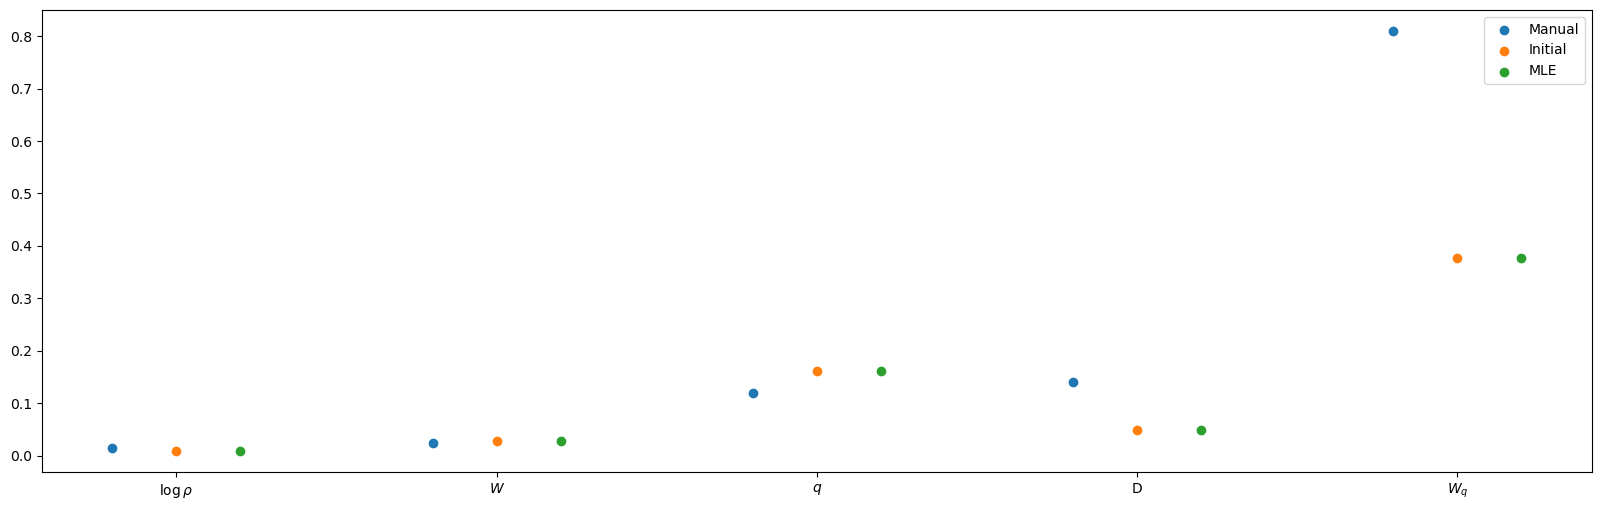

In [ ]:
s_manual = jnp.exp(theta_manual / 2)
s_0 = jnp.exp(theta0_miss / 2)
s_mle = jnp.exp(theta_hat_miss / 2)

k = theta_manual.size
plt.scatter(jnp.arange(k) - 0.2, s_manual, label="Manual")
plt.scatter(jnp.arange(k), s_0, label="Initial")
plt.scatter(jnp.arange(k) + 0.2, s_mle, label="MLE")
plt.xticks(jnp.arange(k), ["$\\log \\rho$", "$W$", "$q$", "D", "$W_q$"])
plt.legend()
plt.show()

In [ ]:
fitted_model_miss = _model_miss(theta_hat_miss, aux)
proposal_la_miss, _ = LA(y_miss, fitted_model_miss, n_iterations)
key, subkey = jrn.split(key)
proposal_meis_miss, _ = MEIS(
    y_miss,
    fitted_model_miss,
    proposal_la_miss.z,
    proposal_la_miss.Omega,
    n_iterations,
    N_meis,
    subkey,
)
key, subkey = jrn.split(key)
samples_miss, lw_miss = pgssm_importance_sampling(
    y_miss,
    fitted_model_miss,
    proposal_meis_miss.z,
    proposal_meis_miss.Omega,
    N_posterior,
    subkey,
)
ess_pct(lw_miss)

Array(75.17543521, dtype=float64)

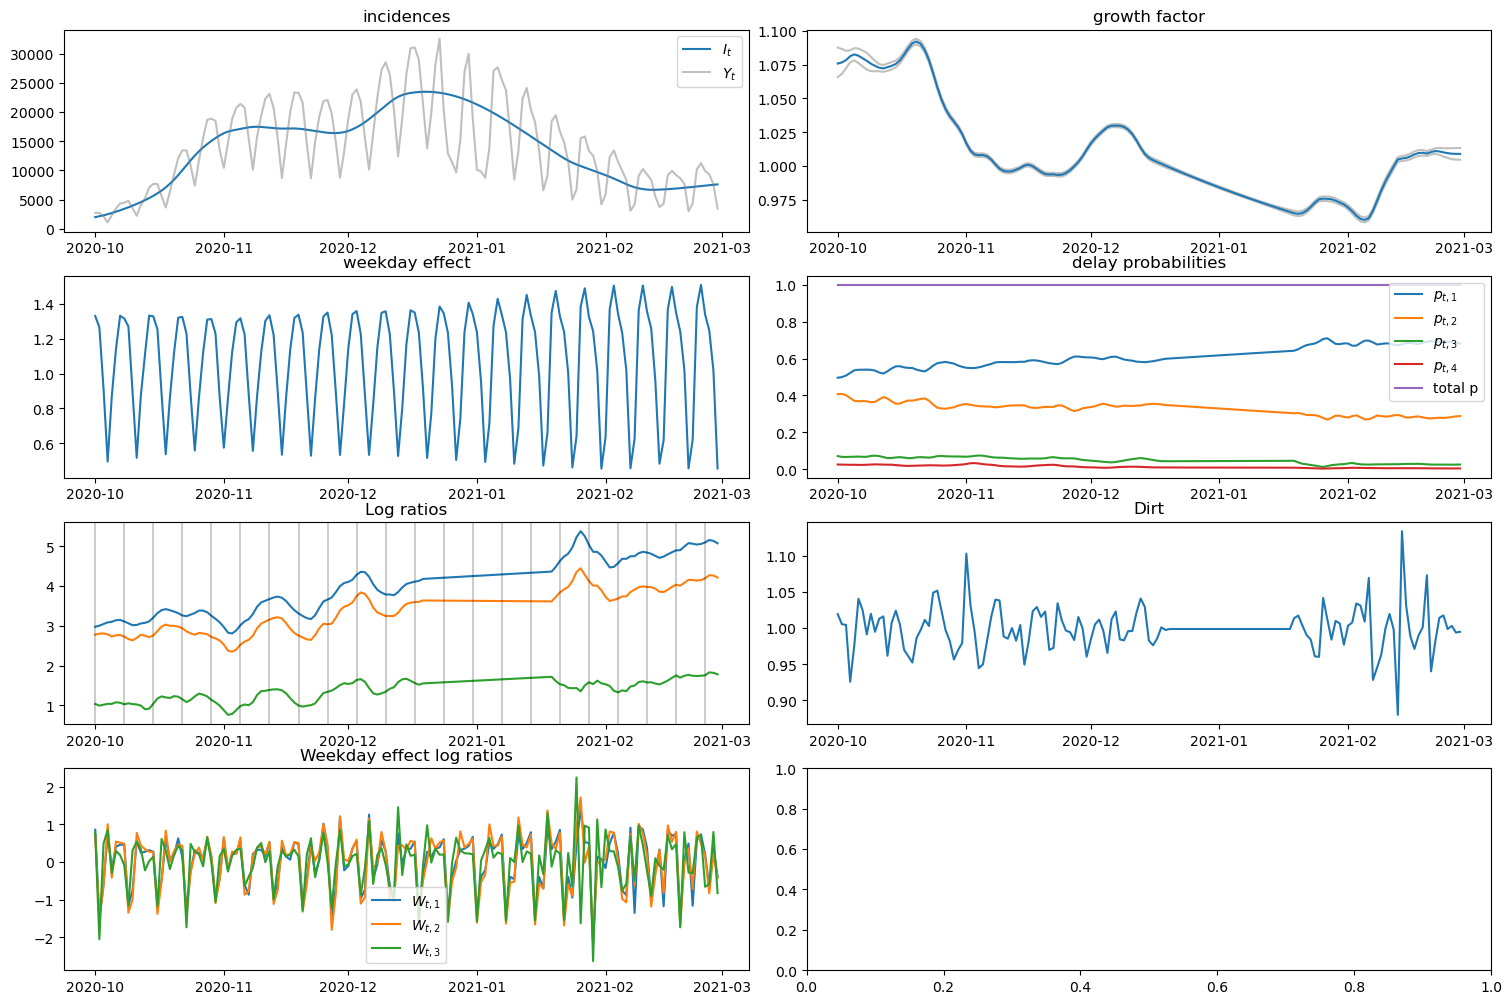

In [ ]:
state_modes_meis = vmap(state_mode, (None, 0))(fitted_model_miss, samples_miss)
x_smooth = mc_integration(state_modes_meis, lw_miss)
x_lower, x_mid, x_upper = prediction_percentiles(
    state_modes_meis, normalize_weights(lw_miss), jnp.array([2.5, 50.0, 97.5]) / 100.0
)

# I_smooth = jnp.exp(x_smooth[:, 0])
I_smooth = mc_integration(jnp.exp(state_modes_meis[:, :, 0]), lw_miss)
rho_smooth = jnp.exp(x_smooth[:, 1])
D_smooth = jnp.exp(x_smooth[:, 2])
W_smooth = jnp.exp(x_smooth[:, 3])
log_ratios = x_smooth[:, 9:12]
log_probs = to_log_probs(log_ratios)

weekday_log_ratios = x_smooth[:, jnp.array([12, 18, 24])]

fig, axs = plt.subplots(4, 2, figsize=(15, 10))

axs = axs.flatten()
fig.tight_layout()

axs[0].set_title("incidences")
axs[0].plot(dates, I_smooth, label="$I_t$")
# axs[0].plot(dates, jnp.exp(x_lower[:, 0]), color="black", linestyle="dashed")
axs[0].plot(dates, y.sum(axis=1), label="$Y_t$", color="grey", alpha=0.5)
axs[0].legend()

axs[1].set_title("growth factor")
axs[1].plot(dates, jnp.exp(x_lower[:, 1]), color="grey", alpha=0.5)
axs[1].plot(dates, jnp.exp(x_upper[:, 1]), color="grey", alpha=0.5)
axs[1].plot(dates, rho_smooth, label="$\\log \\rho_t$")

axs[2].set_title("weekday effect")
axs[2].plot(dates, W_smooth, label="$W_t$")

axs[3].set_title("delay probabilities")

axs[3].plot(dates, jnp.exp(log_probs[:, 0]), label="$p_{t, 1}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 1]), label="$p_{t, 2}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 2]), label="$p_{t, 3}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 3]), label="$p_{t, 4}$")
axs[3].plot(dates, jnp.exp(log_probs).sum(axis=1), label="total p")
axs[3].legend()

axs[4].set_title("Log ratios")
axs[4].plot(dates, log_ratios[:, 0], label="$q_{t, 1}$")
axs[4].plot(dates, log_ratios[:, 1], label="$q_{t, 2}$")
axs[4].plot(dates, log_ratios[:, 2], label="$q_{t, 3}$")
for d in dates[::7]:
    axs[4].axvline(d, color="black", alpha=0.2)

axs[5].set_title("Dirt")
axs[5].plot(dates, D_smooth)

axs[6].set_title("Weekday effect log ratios")
axs[6].plot(dates, weekday_log_ratios[:, 0], label="$W_{t, 1}$")
axs[6].plot(dates, weekday_log_ratios[:, 1], label="$W_{t, 2}$")
axs[6].plot(dates, weekday_log_ratios[:, 2], label="$W_{t, 3}$")
axs[6].legend()
plt.show()

## non-missing model

In [ ]:
# cast to float because nan is a float
theta_manual = jnp.log(
    # s2_log_rho, s2_W, s2_q, s2_M, s2_Wq
    jnp.array([0.015**2, 0.024**2, 0.12**2, 0.14**2, 0.81**2])
)
aux = (np1, 4)
if refit:
    theta0_result = initial_theta(y, _model, theta_manual, aux, n_iterations)
    theta0 = theta0_result.x
    theta0_result

In [ ]:
if refit:
    key, subkey = jrn.split(key)
    mle_result = mle_pgssm(y, _model, theta0, aux, n_iterations, N_mle, subkey)
    theta_hat = mle_result.x
    mle_result

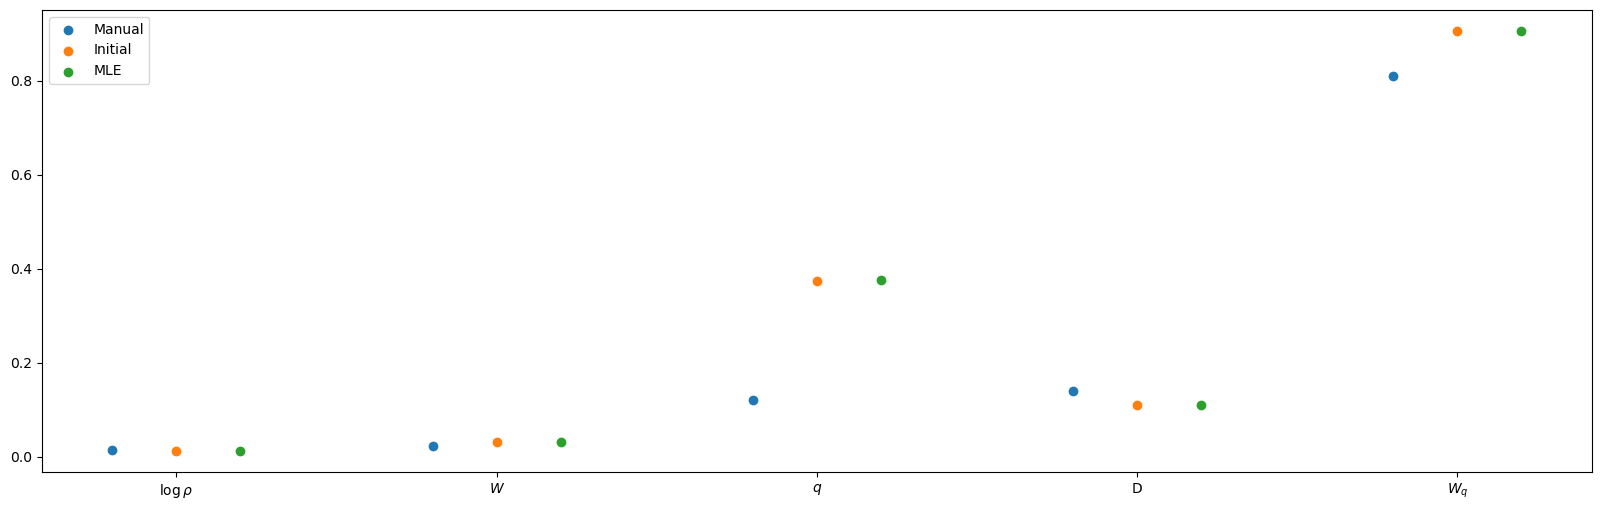

In [ ]:
s_manual = jnp.exp(theta_manual / 2)
s_0 = jnp.exp(theta0 / 2)
s_mle = jnp.exp(theta_hat / 2)

k = theta_manual.size
plt.scatter(jnp.arange(k) - 0.2, s_manual, label="Manual")
plt.scatter(jnp.arange(k), s_0, label="Initial")
plt.scatter(jnp.arange(k) + 0.2, s_mle, label="MLE")
plt.xticks(jnp.arange(k), ["$\\log \\rho$", "$W$", "$q$", "D", "$W_q$"])
plt.legend()
plt.show()

In [ ]:
fitted_model = _model(theta_hat, aux)
proposal_la, _ = LA(y, fitted_model, n_iterations)
key, subkey = jrn.split(key)
proposal_meis, _ = MEIS(
    y, fitted_model, proposal_la.z, proposal_la.Omega, n_iterations, N_meis, subkey
)
key, subkey = jrn.split(key)
samples, lw = pgssm_importance_sampling(
    y, fitted_model, proposal_meis.z, proposal_meis.Omega, N_posterior, subkey
)
ess_pct(lw)

Array(52.83872881, dtype=float64)

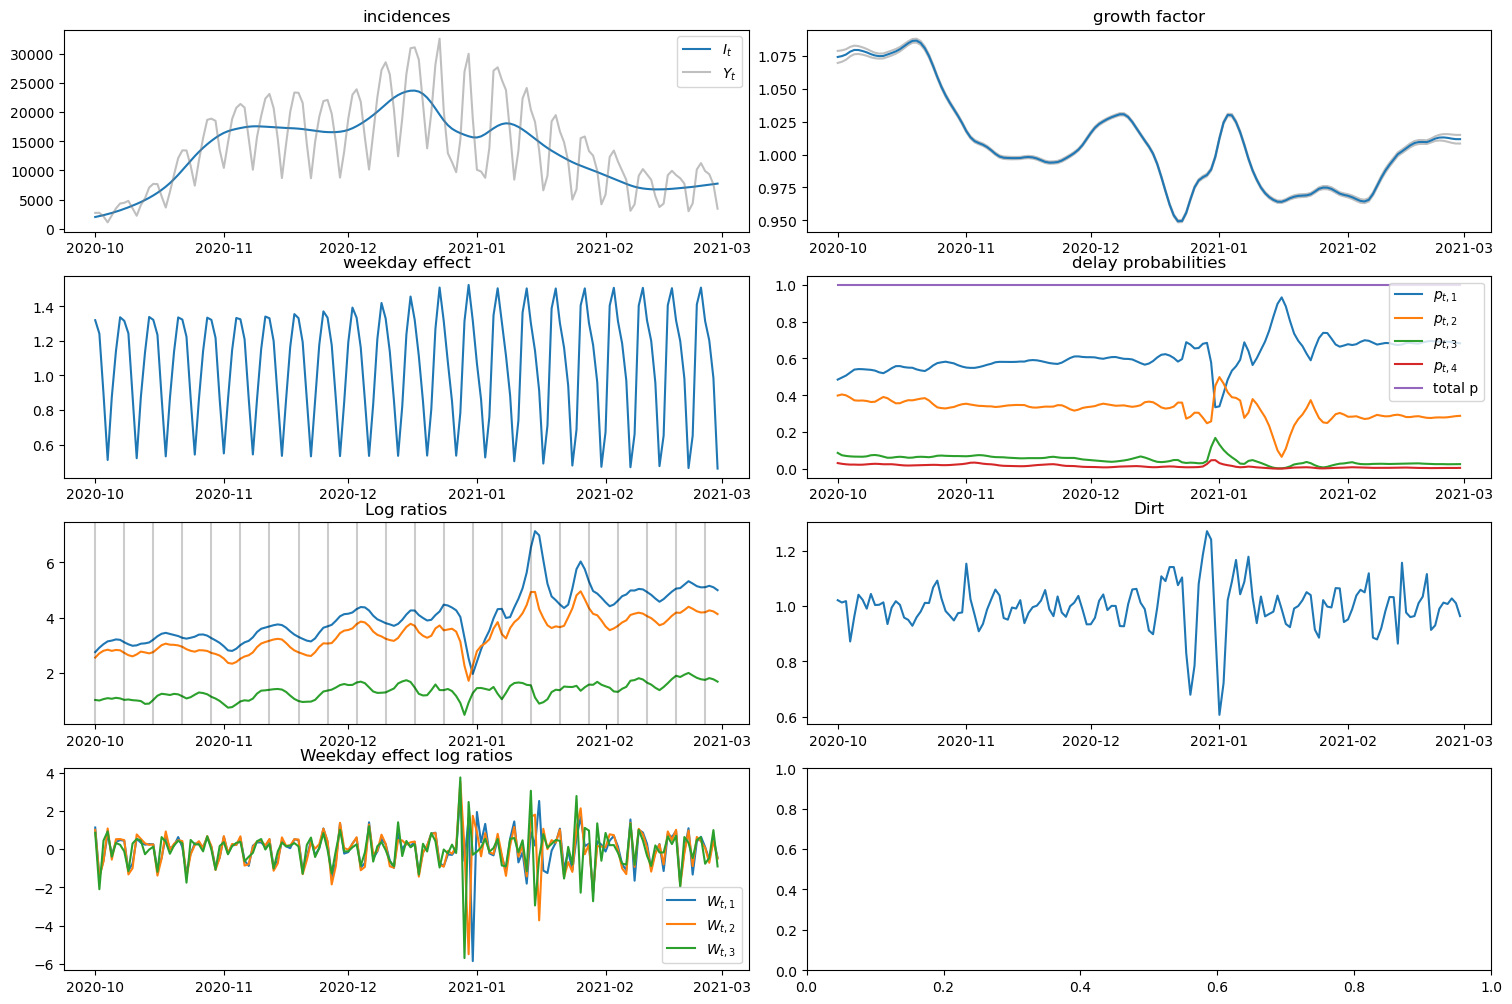

In [ ]:
state_modes_meis = vmap(state_mode, (None, 0))(fitted_model, samples)
x_smooth = mc_integration(state_modes_meis, lw)
x_lower, x_mid, x_upper = prediction_percentiles(
    state_modes_meis, normalize_weights(lw), jnp.array([2.5, 50.0, 97.5]) / 100.0
)

# I_smooth = jnp.exp(x_smooth[:, 0])
I_smooth = mc_integration(jnp.exp(state_modes_meis[:, :, 0]), lw)
rho_smooth = jnp.exp(x_smooth[:, 1])
D_smooth = jnp.exp(x_smooth[:, 2])
W_smooth = jnp.exp(x_smooth[:, 3])
log_ratios = x_smooth[:, 9:12]
log_probs = to_log_probs(log_ratios)

weekday_log_ratios = x_smooth[:, jnp.array([12, 18, 24])]

fig, axs = plt.subplots(4, 2, figsize=(15, 10))

axs = axs.flatten()
fig.tight_layout()

axs[0].set_title("incidences")
axs[0].plot(dates, I_smooth, label="$I_t$")
# axs[0].plot(dates, jnp.exp(x_lower[:, 0]), color="black", linestyle="dashed")
axs[0].plot(dates, y.sum(axis=1), label="$Y_t$", color="grey", alpha=0.5)
axs[0].legend()

axs[1].set_title("growth factor")
axs[1].plot(dates, jnp.exp(x_lower[:, 1]), color="grey", alpha=0.5)
axs[1].plot(dates, jnp.exp(x_upper[:, 1]), color="grey", alpha=0.5)
axs[1].plot(dates, rho_smooth, label="$\\log \\rho_t$")

axs[2].set_title("weekday effect")
axs[2].plot(dates, W_smooth, label="$W_t$")

axs[3].set_title("delay probabilities")

axs[3].plot(dates, jnp.exp(log_probs[:, 0]), label="$p_{t, 1}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 1]), label="$p_{t, 2}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 2]), label="$p_{t, 3}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 3]), label="$p_{t, 4}$")
axs[3].plot(dates, jnp.exp(log_probs).sum(axis=1), label="total p")
axs[3].legend()

axs[4].set_title("Log ratios")
axs[4].plot(dates, log_ratios[:, 0], label="$q_{t, 1}$")
axs[4].plot(dates, log_ratios[:, 1], label="$q_{t, 2}$")
axs[4].plot(dates, log_ratios[:, 2], label="$q_{t, 3}$")
for d in dates[::7]:
    axs[4].axvline(d, color="black", alpha=0.2)

axs[5].set_title("Dirt")
axs[5].plot(dates, D_smooth)

axs[6].set_title("Weekday effect log ratios")
axs[6].plot(dates, weekday_log_ratios[:, 0], label="$W_{t, 1}$")
axs[6].plot(dates, weekday_log_ratios[:, 1], label="$W_{t, 2}$")
axs[6].plot(dates, weekday_log_ratios[:, 2], label="$W_{t, 3}$")
axs[6].legend()
plt.show()

## Storing results

In [ ]:
# theta
df_theta_miss = pd.DataFrame.from_records(
    jnp.vstack([theta_manual, theta0_miss, theta_hat_miss]),
    columns=["log rho", "W", "q", "M", "W_q"],
    index=["manual", "initial", "MLE"],
)
df_theta_miss.to_csv(
    here() / "data/results/4_christmas_model/thetas_miss.csv", index_label="method"
)
df_theta_miss

,log rho,W,q,M,W_q
manual,-8.399410155759854,-7.459402897268383,-4.240527072400182,-3.9322257127456655,-0.421442062631305
initial,-9.498473528009953,-7.176173500070751,-3.6539720582817656,-6.063721127466821,-1.95510472147738
MLE,-9.491112854055851,-7.167914274896476,-3.653098128651405,-6.054349162377304,-1.9545497948842407


In [ ]:
df_theta = pd.DataFrame.from_records(
    jnp.vstack([theta_manual, theta0, theta_hat]),
    columns=["log rho", "W", "q", "M", "W_q"],
    index=["manual", "initial", "MLE"],
)
df_theta.to_csv(
    here() / "data/results/4_christmas_model/thetas.csv", index_label="method"
)
df_theta

,log rho,W,q,M,W_q
manual,-8.399410155759854,-7.459402897268383,-4.240527072400182,-3.9322257127456655,-0.421442062631305
initial,-8.748476043273607,-6.915487136896888,-1.9623090799543892,-4.408467670632922,-0.1990654788396088
MLE,-8.748555060635622,-6.9155143502858305,-1.9612130790596172,-4.408284537651647,-0.1985909535002628


In [ ]:
from isssm.importance_sampling import prediction
from jaxtyping import Float, Array

# predictions

# date / name / mean / sd / percentiles

key, subkey_prediction = jrn.split(key)


def f_predict(x, s, y):
    probs = jnp.exp(to_log_probs(x[:, 9:12]))
    probs_signal = jnp.exp(to_log_probs(s[:, 1:]))
    I = jnp.exp(x[:, 0:1])
    rho = jnp.exp(x[:, 1:2])
    M = jnp.exp(x[:, 2:3])
    W = jnp.exp(x[:, 3:4])
    runn_W = jnp.convolve(jnp.exp(x[:, 3]), jnp.ones(7) / 7, mode="same")[:, None]
    Wq = jnp.exp(x[:, jnp.array([12, 18, 24])])
    y_fill_in_total = jnp.full(I.shape, y[missing_inds].sum())
    return jnp.concatenate(
        [I, rho, M, W, runn_W, probs, probs_signal, Wq, y_fill_in_total],
        -1,
    )


def stacked_prediction(f):
    mean, sd, quantiles = prediction(
        f,
        y,
        proposal_meis,
        fitted_model,
        N_posterior,
        subkey_prediction,
        percentiles_of_interest,
    )
    return jnp.vstack((mean[None], sd[None], quantiles))


def stacked_prediction_miss(f):
    mean, sd, quantiles = prediction(
        f,
        y_miss,
        proposal_meis_miss,
        fitted_model_miss,
        N_posterior,
        subkey_prediction,
        percentiles_of_interest,
        fitted_model,
    )
    return jnp.vstack((mean[None], sd[None], quantiles))


jnp.save(
    here() / "data/results/4_christmas_model/predictions.npy",
    stacked_prediction(f_predict),
)
jnp.save(
    here() / "data/results/4_christmas_model/predictions_miss.npy",
    stacked_prediction_miss(f_predict),
)